In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
x1 = 0
x2 = 30000
x3 = 70000
z_h = 100
D = 100
s_x = 7
s_y = 7
U_h0 = 10
k = 0.4 # Von Karman constant [-]
z_0lo = 0.0001 # surface rughness length [m]

In [3]:
def calculate_wind_speed(x1, x2, x3, z_h, D, C_T, s_x, s_y):

    ct = (np.pi * C_T * D**2)/(8 * s_x*D * s_y*D)
    print(f"ct: {ct:.6f}")

    nu_star = 28 * np.sqrt(ct)
    print(f"nu_star: {nu_star:.2f}")
    
    beta =  nu_star / (1 + nu_star)
    print(f"beta: {beta:.2f}")
    
    z0_WF = z_h * (1 + D/(2 * z_h))**beta * np.exp(-k * (ct + (k/np.log((z_h / z_0lo) * (1 - D/(2 * z_h))**beta))**2)**-0.5)
    print(f"z0_WF: {z0_WF:.2f}")

    x1 = x1
    x2 = x2
    x3 = x3
    x = np.linspace(x1, x3, x3)

    h1 = np.full_like(x, np.nan, dtype=float)
    h2 = np.full_like(x, np.nan, dtype=float)

    h1[x > x1] = z_h + ((x[x > x1]) / z0_WF)**(4/5)
    h2[x > x2] = ((x[x>x2]-x2)/z0_WF)**(4/5)

    uw = np.full_like(x, np.nan, dtype=float)
    uw[0] = U_h0

    idx1 = h1 >= z_h
    uw[idx1] = U_h0 * (np.log(h1[idx1] / z_0lo) * np.log(z_h / z0_WF)) / (np.log(h1[idx1] / z0_WF) * np.log(z_h/z_0lo))

    idx2 = (x > x2) & (h2 >= z_h)
    uw[idx2] = U_h0 * (np.log(h1[idx2] / z_0lo) * np.log(h2[idx2] / z0_WF)) / (np.log(h1[idx2] / z0_WF) * np.log(h2[idx2] / z_0lo))

    return x, uw

ct: 0.005610
nu_star: 2.10
beta: 0.68
z0_WF: 0.92


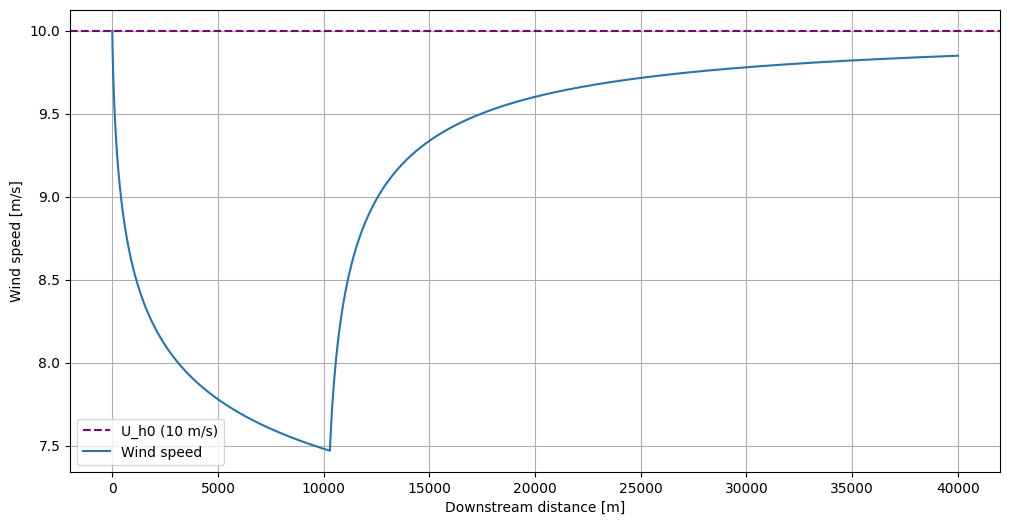

In [4]:
# calculate_wind_speed(x1, x2, x3, z_h, D, CT, s_x, s_y):
x, uw = calculate_wind_speed(0, 10000, 40001, 100, 100, 0.7, 7, 7)

plt.figure(figsize=(12, 6))
plt.axhline(y=U_h0, color='purple', linestyle='--', label=f'U_h0 ({U_h0:.0f} m/s)')
plt.plot(x, uw, label='Wind speed', color='#1f77b4')
plt.xlabel('Downstream distance [m]')
plt.ylabel('Wind speed [m/s]')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# ct_0.8: 0.006411
# ct_0.7: 0.005610
# d_ct: 0.001 ish

In [5]:
u = np.arange(0, 26, .5)  # [m/s]
CT = np.array([0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0])
tc = np.rec.fromarrays([u, CT], names='u, CT')

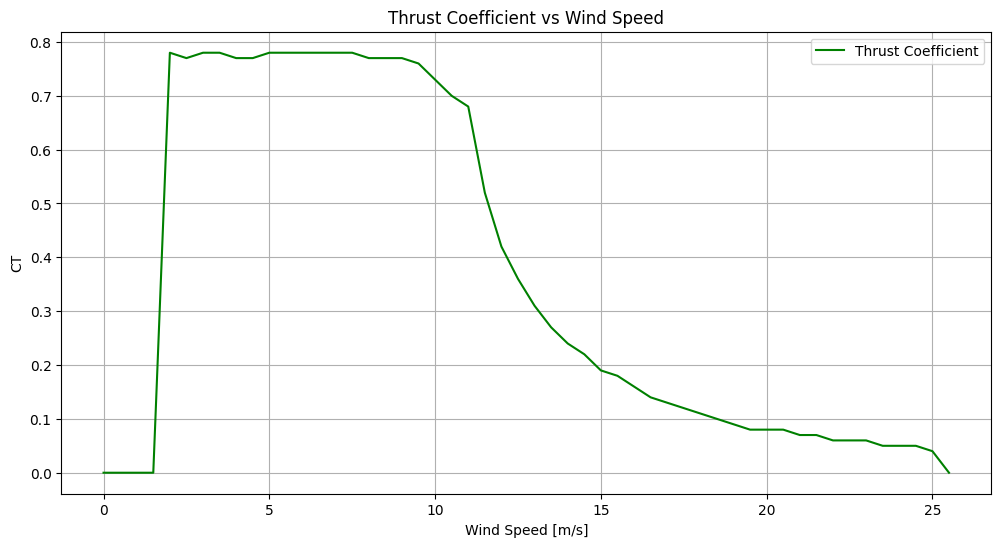

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(tc['u'], tc['CT'], label='Thrust Coefficient', color='green')
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('CT')
plt.title('Thrust Coefficient vs Wind Speed')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [7]:
# Interpolate to 100 points
u_interp = np.linspace(u.min(), u.max(), 1000)
CT_interp = interp1d(u, CT, kind='linear')(u_interp)

# Create structured array
tc_interp = np.rec.fromarrays([u_interp, CT_interp], names='u, CT')

In [8]:
def calculate_wind_speed_2(x1, x2, x3, z_h, D, s_x, s_y):

    uw_x = uw
    
    # Get the index in tc.u that is closest to each uw_x
    idx = np.abs(uw_x[:, None] - tc_interp.u).argmin(axis=1)

    # Use those indices to extract CT values
    CT_x = tc_interp.CT[idx]

    ct = (np.pi * CT_x * D**2) / (8 * s_x * D * s_y * D)

    print("ct: ", ct)
    nu_star = 28 * np.sqrt(ct)
    print("nu_star: ", nu_star)
    beta =  nu_star / (1 + nu_star)
    print("beta: ", beta)

    z0_WF = z_h * (1 + D/(2 * z_h))**beta * np.exp(-k * (ct + (k/np.log((z_h / z_0lo) * (1 - D/(2 * z_h))**beta))**2)**-0.5)
    print("z0_WF: ", z0_WF)

    x = np.linspace(x1, x3+1, x3+1)

    h1 = np.full_like(x, np.nan, dtype=float)
    h2 = np.full_like(x, np.nan, dtype=float)

    h1[x >= x1] = z_h + ((x[x >= x1]) / z0_WF)**(4/5)
    h2[x > x2] = ((x[x>x2]-x2)/z0_WF[x>x2])**(4/5)

    uw_x = np.full_like(x, np.nan, dtype=float)

    idx1 = h1 >= z_h
    uw_x[idx1] = U_h0 * (np.log(h1[idx1] / z_0lo) * np.log(z_h / z0_WF)) / (np.log(h1[idx1] / z0_WF) * np.log(z_h/z_0lo))

    idx2 = (x > x2) & (h2 >= z_h)
    uw_x[idx2] = U_h0 * (np.log(h1[idx2] / z_0lo) * np.log(h2[idx2] / z0_WF[idx2])) / (np.log(h1[idx2] / z0_WF[idx2]) * np.log(h2[idx2] / z_0lo))

    return x, uw_x, ct

ct: 0.006411
nu_star: 2.24
beta: 0.69
z0_WF: 1.23
ct:  [0.00584753 0.0058598  0.0058598  ... 0.00599482 0.00599482 0.00599482]
nu_star:  [2.14113546 2.14338143 2.14338143 ... 2.16793354 2.16793354 2.16793354]
beta:  [0.68164378 0.68187125 0.68187125 ... 0.68433681 0.68433681 0.68433681]
z0_WF:  [1.01161077 1.01619776 1.01619776 ... 1.06719297 1.06719297 1.06719297]


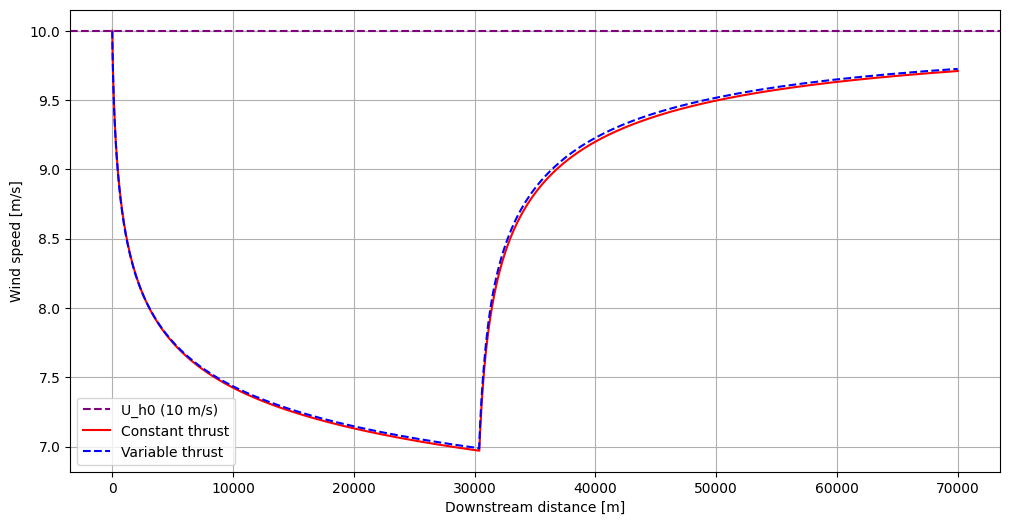

In [19]:
x, uw = calculate_wind_speed(x1, x2, x3+1, z_h, D, 0.8, s_x, s_y)
x_x, uw_x, ct_var = calculate_wind_speed_2(x1, x2, x3, z_h, D, s_x, s_y)

plt.figure(figsize=(12, 6))
plt.axhline(y=U_h0, color='purple', linestyle='--', label=f'U_h0 ({U_h0:.0f} m/s)')
plt.plot(x, uw, label='Constant thrust', color='red')
plt.plot(x_x, uw_x, label='Variable thrust', color='blue', linestyle='dashed')
plt.xlabel('Downstream distance [m]')
plt.ylabel('Wind speed [m/s]')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [22]:
print(uw[-1])
print(uw_x[-1])
print(((10-(10-uw_x[-1])) - (10-(10-uw[-1])))/(10-(10-uw_x[-1]))*100)

print((0.291 - 0.276)/0.291)

9.709353285932272
9.72480254685303
0.15886452034708368
0.05154639175257718


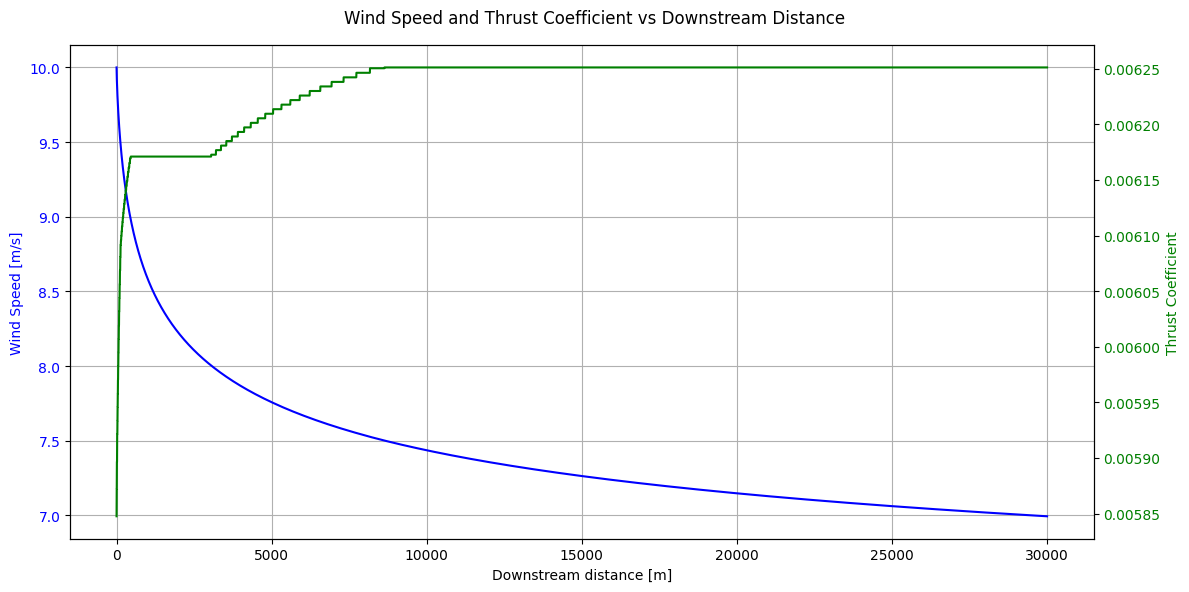

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot uw_x on the primary y-axis
ax1.plot(x_x[:x2], uw_x[:x2], label='Wind Speed (uw_x)', color='blue')
ax1.set_xlabel('Downstream distance [m]')
ax1.set_ylabel('Wind Speed [m/s]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for ct_var
ax2 = ax1.twinx()
ax2.plot(x_x[:x2], ct_var[:x2], label='Thrust Coefficient (ct_var)', color='green')
ax2.set_ylabel('Thrust Coefficient', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title and show the plot
fig.suptitle('Wind Speed and Thrust Coefficient vs Downstream Distance')
fig.tight_layout()
plt.show()